# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   wis         1206 non-null   int64 
 1   reflex      1206 non-null   int64 
 2   str         1206 non-null   int64 
 3   hp          1206 non-null   int64 
 4   fortitude   1206 non-null   int64 
 5   focus       1206 non-null   int32 
 6   cha         1206 non-null   int64 
 7   dex         1206 non-null   int64 
 8   int         1206 non-null   int64 
 9   level       1206 non-null   int64 
 10  ac          1206 non-null   int64 
 11  perception  1206 non-null   int64 
 12  book        1206 non-null   object
 13  con         1206 non-null   int64 
 14  will        1206 non-null   int64 
dtypes: int32(1), int64(13), object(1)
memory usage: 146.0+ KB


In [3]:
df.head()

,wis,reflex,str,hp,fortitude,focus,cha,dex,int,level,ac,perception,book,con,will
0,2,19,7,215,22,1,1,2,1,10,29,20,Pathfinder Bestiary,5,17
1,2,14,9,220,21,0,1,0,-4,10,28,16,Pathfinder Bestiary,5,16
2,3,17,7,175,20,0,-2,3,-4,8,25,17,Pathfinder Bestiary,6,15
3,5,29,7,315,30,1,6,4,6,17,41,30,Pathfinder Bestiary,5,32
4,1,10,-5,20,6,1,1,3,-1,1,16,6,Pathfinder Bestiary,1,4


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


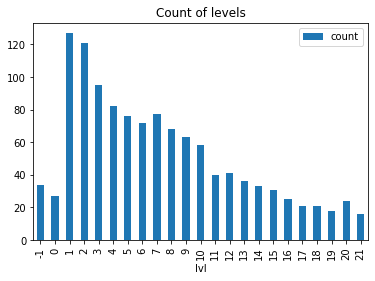

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 13
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.51
MAE: 0.36


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "expanded", rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.21
RMSE test: 0.51


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

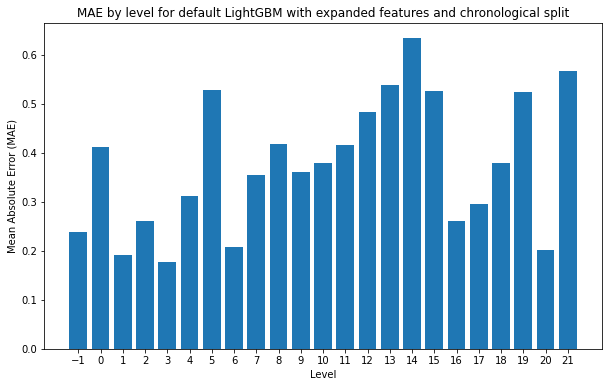

In [18]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with expanded features and chronological split",
)

In [19]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions([0.5, 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.51

Round type: 0.5
RMSE: 0.55

Round type: 0.33
RMSE: 0.54

Round type: 0.45
RMSE: 0.54



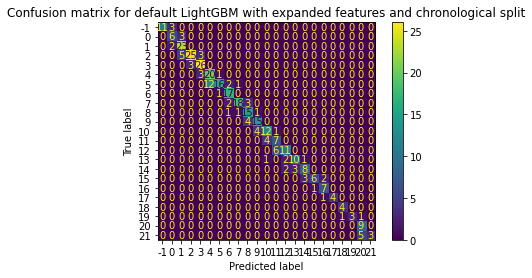

In [20]:
plot_confusion_matrix(
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with expanded features and chronological split",
)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 13:56:28,317] A new study created in memory with name: no-name-7a9bc0d3-ab34-4955-a881-3714b156d517
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.17495 + 0.0358615
[200]	cv_agg's l2: 0.172929 + 0.0346286


feature_fraction, val_score: 0.172148:  14%|######4                                      | 1/7 [00:02<00:13,  2.32s/it]

[300]	cv_agg's l2: 0.173294 + 0.0348755
Early stopping, best iteration is:
[225]	cv_agg's l2: 0.172148 + 0.0342682
[100]	cv_agg's l2: 0.166786 + 0.0270658
[200]	cv_agg's l2: 0.162584 + 0.025227
[300]	cv_agg's l2: 0.161879 + 0.0252672


feature_fraction, val_score: 0.161790:  29%|############8                                | 2/7 [00:04<00:12,  2.52s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.16179 + 0.0250665
[100]	cv_agg's l2: 0.166714 + 0.0231257
[200]	cv_agg's l2: 0.163317 + 0.0203853
[300]	cv_agg's l2: 0.163122 + 0.0203494


feature_fraction, val_score: 0.161790:  43%|###################2                         | 3/7 [00:07<00:10,  2.56s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.16179 + 0.0250665
[100]	cv_agg's l2: 0.189399 + 0.0383444
[200]	cv_agg's l2: 0.186184 + 0.036373
[300]	cv_agg's l2: 0.185642 + 0.0359738


feature_fraction, val_score: 0.161790:  57%|#########################7                   | 4/7 [00:10<00:08,  2.68s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.16179 + 0.0250665
[100]	cv_agg's l2: 0.180073 + 0.0438197
[200]	cv_agg's l2: 0.17646 + 0.0402654
[300]	cv_agg's l2: 0.176118 + 0.0395711


feature_fraction, val_score: 0.161790:  71%|################################1            | 5/7 [00:13<00:05,  2.65s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.16179 + 0.0250665
[100]	cv_agg's l2: 0.181678 + 0.0305417
[200]	cv_agg's l2: 0.178113 + 0.0284832
[300]	cv_agg's l2: 0.178184 + 0.0281777


feature_fraction, val_score: 0.161790:  86%|######################################5      | 6/7 [00:15<00:02,  2.66s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.16179 + 0.0250665
[100]	cv_agg's l2: 0.172172 + 0.0318777
[200]	cv_agg's l2: 0.170319 + 0.0295371
[300]	cv_agg's l2: 0.171107 + 0.0291659


feature_fraction, val_score: 0.161790: 100%|#############################################| 7/7 [00:18<00:00,  2.63s/it]


Early stopping, best iteration is:
[295]	cv_agg's l2: 0.16179 + 0.0250665


num_leaves, val_score: 0.161790:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.166786 + 0.0270658
[200]	cv_agg's l2: 0.162584 + 0.025227
[300]	cv_agg's l2: 0.161879 + 0.0252672


num_leaves, val_score: 0.161790:   5%|##5                                               | 1/20 [00:03<00:58,  3.10s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.16179 + 0.0250665
[100]	cv_agg's l2: 0.166786 + 0.0270658
[200]	cv_agg's l2: 0.162584 + 0.025227
[300]	cv_agg's l2: 0.161879 + 0.0252672


num_leaves, val_score: 0.161790:  10%|#####                                             | 2/20 [00:06<00:58,  3.24s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.16179 + 0.0250665
[100]	cv_agg's l2: 0.166786 + 0.0270658
[200]	cv_agg's l2: 0.162584 + 0.025227
[300]	cv_agg's l2: 0.161879 + 0.0252672


num_leaves, val_score: 0.161790:  15%|#######5                                          | 3/20 [00:09<00:57,  3.38s/it]

Early stopping, best iteration is:
[295]	cv_agg's l2: 0.16179 + 0.0250665
[100]	cv_agg's l2: 0.164748 + 0.0269342
[200]	cv_agg's l2: 0.161537 + 0.0251767


num_leaves, val_score: 0.161266:  20%|##########                                        | 4/20 [00:13<00:55,  3.45s/it]

[300]	cv_agg's l2: 0.162456 + 0.0248587
Early stopping, best iteration is:
[213]	cv_agg's l2: 0.161266 + 0.0251218
[100]	cv_agg's l2: 0.319334 + 0.0602125
[200]	cv_agg's l2: 0.283309 + 0.0552855


num_leaves, val_score: 0.161266:  25%|############5                                     | 5/20 [00:14<00:37,  2.47s/it]

[300]	cv_agg's l2: 0.275632 + 0.0532089
Early stopping, best iteration is:
[213]	cv_agg's l2: 0.161266 + 0.0251218
[100]	cv_agg's l2: 0.165675 + 0.0283348
[200]	cv_agg's l2: 0.161887 + 0.0276593
[300]	cv_agg's l2: 0.160227 + 0.0271465


num_leaves, val_score: 0.159893:  30%|###############                                   | 6/20 [00:19<00:45,  3.24s/it]

[400]	cv_agg's l2: 0.161362 + 0.0276026
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.168613 + 0.0307568
[200]	cv_agg's l2: 0.162176 + 0.0284882
[300]	cv_agg's l2: 0.162266 + 0.0280825


num_leaves, val_score: 0.159893:  35%|#################5                                | 7/20 [00:22<00:42,  3.28s/it]

[400]	cv_agg's l2: 0.16264 + 0.0289285
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.166786 + 0.0270658
[200]	cv_agg's l2: 0.162584 + 0.025227
[300]	cv_agg's l2: 0.161879 + 0.0252672


num_leaves, val_score: 0.159893:  40%|####################                              | 8/20 [00:27<00:45,  3.75s/it]

[400]	cv_agg's l2: 0.163017 + 0.0259765
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.166786 + 0.0270658
[200]	cv_agg's l2: 0.162584 + 0.025227
[300]	cv_agg's l2: 0.161879 + 0.0252672


num_leaves, val_score: 0.159893:  45%|######################5                           | 9/20 [00:31<00:42,  3.87s/it]

[400]	cv_agg's l2: 0.163017 + 0.0259765
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.166786 + 0.0270658
[200]	cv_agg's l2: 0.162584 + 0.025227
[300]	cv_agg's l2: 0.161879 + 0.0252672


num_leaves, val_score: 0.159893:  50%|########################5                        | 10/20 [00:35<00:40,  4.08s/it]

[400]	cv_agg's l2: 0.163017 + 0.0259765
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.166786 + 0.0270658
[200]	cv_agg's l2: 0.162584 + 0.025227
[300]	cv_agg's l2: 0.161879 + 0.0252672


num_leaves, val_score: 0.159893:  55%|##########################9                      | 11/20 [00:40<00:37,  4.13s/it]

[400]	cv_agg's l2: 0.163017 + 0.0259765
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.166786 + 0.0270658
[200]	cv_agg's l2: 0.162584 + 0.025227
[300]	cv_agg's l2: 0.161879 + 0.0252672


num_leaves, val_score: 0.159893:  60%|#############################4                   | 12/20 [00:44<00:33,  4.14s/it]

[400]	cv_agg's l2: 0.163017 + 0.0259765
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.166786 + 0.0270658
[200]	cv_agg's l2: 0.162584 + 0.025227
[300]	cv_agg's l2: 0.161879 + 0.0252672


num_leaves, val_score: 0.159893:  65%|###############################8                 | 13/20 [00:48<00:28,  4.11s/it]

[400]	cv_agg's l2: 0.163017 + 0.0259765
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.166786 + 0.0270658
[200]	cv_agg's l2: 0.162584 + 0.025227
[300]	cv_agg's l2: 0.161879 + 0.0252672


num_leaves, val_score: 0.159893:  70%|##################################3              | 14/20 [00:53<00:27,  4.53s/it]

[400]	cv_agg's l2: 0.163017 + 0.0259765
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.166786 + 0.0270658
[200]	cv_agg's l2: 0.162584 + 0.025227
[300]	cv_agg's l2: 0.161879 + 0.0252672


num_leaves, val_score: 0.159893:  75%|####################################7            | 15/20 [00:58<00:22,  4.48s/it]

[400]	cv_agg's l2: 0.163017 + 0.0259765
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.166786 + 0.0270658
[200]	cv_agg's l2: 0.162584 + 0.025227
[300]	cv_agg's l2: 0.161879 + 0.0252672


num_leaves, val_score: 0.159893:  80%|#######################################2         | 16/20 [01:02<00:17,  4.45s/it]

[400]	cv_agg's l2: 0.163017 + 0.0259765
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.166786 + 0.0270658
[200]	cv_agg's l2: 0.162584 + 0.025227
[300]	cv_agg's l2: 0.161879 + 0.0252672


num_leaves, val_score: 0.159893:  80%|#######################################2         | 16/20 [01:07<00:17,  4.45s/it]

[400]	cv_agg's l2: 0.163017 + 0.0259765
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535


num_leaves, val_score: 0.159893:  85%|#########################################6       | 17/20 [01:07<00:13,  4.53s/it]

[100]	cv_agg's l2: 0.166786 + 0.0270658
[200]	cv_agg's l2: 0.162584 + 0.025227
[300]	cv_agg's l2: 0.161879 + 0.0252672


num_leaves, val_score: 0.159893:  90%|############################################1    | 18/20 [01:12<00:09,  4.82s/it]

[400]	cv_agg's l2: 0.163017 + 0.0259765
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.166786 + 0.0270658
[200]	cv_agg's l2: 0.162584 + 0.025227
[300]	cv_agg's l2: 0.161879 + 0.0252672


num_leaves, val_score: 0.159893:  95%|##############################################5  | 19/20 [01:17<00:04,  4.67s/it]

[400]	cv_agg's l2: 0.163017 + 0.0259765
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.165959 + 0.0290675
[200]	cv_agg's l2: 0.162286 + 0.026613
[300]	cv_agg's l2: 0.161774 + 0.026345


num_leaves, val_score: 0.159893: 100%|#################################################| 20/20 [01:20<00:00,  4.05s/it]


[400]	cv_agg's l2: 0.162691 + 0.0260986
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535


bagging, val_score: 0.159893:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.171603 + 0.0344427
[200]	cv_agg's l2: 0.165401 + 0.0322998
[300]	cv_agg's l2: 0.163749 + 0.0298429


bagging, val_score: 0.159893:  10%|#####3                                               | 1/10 [00:04<00:36,  4.01s/it]

[400]	cv_agg's l2: 0.163376 + 0.0284442
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.213497 + 0.0446119
[200]	cv_agg's l2: 0.201818 + 0.0418824
[300]	cv_agg's l2: 0.198189 + 0.040346


bagging, val_score: 0.159893:  20%|##########6                                          | 2/10 [00:06<00:23,  2.99s/it]

[400]	cv_agg's l2: 0.195755 + 0.0356238
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.167158 + 0.0332425
[200]	cv_agg's l2: 0.163666 + 0.0318207
[300]	cv_agg's l2: 0.1639 + 0.0310192


bagging, val_score: 0.159893:  30%|###############9                                     | 3/10 [00:09<00:23,  3.32s/it]

[400]	cv_agg's l2: 0.164144 + 0.0312625
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.183549 + 0.0381595
[200]	cv_agg's l2: 0.17828 + 0.0309415
[300]	cv_agg's l2: 0.175891 + 0.0290741


bagging, val_score: 0.159893:  40%|#####################2                               | 4/10 [00:13<00:20,  3.37s/it]

[400]	cv_agg's l2: 0.176127 + 0.0288205
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.181687 + 0.0328479
[200]	cv_agg's l2: 0.177217 + 0.0324042
[300]	cv_agg's l2: 0.175947 + 0.030729


bagging, val_score: 0.159893:  50%|##########################5                          | 5/10 [00:17<00:17,  3.51s/it]

[400]	cv_agg's l2: 0.177053 + 0.0309371
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.189716 + 0.0318778
[200]	cv_agg's l2: 0.183984 + 0.0312866
[300]	cv_agg's l2: 0.181767 + 0.0298721


bagging, val_score: 0.159893:  60%|###############################8                     | 6/10 [00:20<00:13,  3.37s/it]

[400]	cv_agg's l2: 0.1797 + 0.0276942
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.235779 + 0.0512971
[200]	cv_agg's l2: 0.21551 + 0.0396851
[300]	cv_agg's l2: 0.216175 + 0.0411651


bagging, val_score: 0.159893:  70%|#####################################                | 7/10 [00:22<00:08,  2.99s/it]

[400]	cv_agg's l2: 0.208517 + 0.0390915
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.17909 + 0.0345379
[200]	cv_agg's l2: 0.17449 + 0.0275634
[300]	cv_agg's l2: 0.174598 + 0.026948


bagging, val_score: 0.159893:  80%|##########################################4          | 8/10 [00:26<00:06,  3.37s/it]

[400]	cv_agg's l2: 0.174997 + 0.0271299
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.194807 + 0.0416755
[200]	cv_agg's l2: 0.185257 + 0.0346267
[300]	cv_agg's l2: 0.180357 + 0.0308064


bagging, val_score: 0.159893:  90%|###############################################7     | 9/10 [00:29<00:03,  3.26s/it]

[400]	cv_agg's l2: 0.177935 + 0.0279185
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.179491 + 0.0355389
[200]	cv_agg's l2: 0.173717 + 0.0320939
[300]	cv_agg's l2: 0.172105 + 0.0302881


bagging, val_score: 0.159893: 100%|####################################################| 10/10 [00:33<00:00,  3.37s/it]


[400]	cv_agg's l2: 0.171168 + 0.0285419
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535


feature_fraction_stage2, val_score: 0.159893:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.16576 + 0.0322685
[200]	cv_agg's l2: 0.161382 + 0.0300366
[300]	cv_agg's l2: 0.161089 + 0.0297448


feature_fraction_stage2, val_score: 0.159893:  17%|######3                               | 1/6 [00:03<00:19,  3.93s/it]

[400]	cv_agg's l2: 0.161904 + 0.0296827
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.165782 + 0.0226515
[200]	cv_agg's l2: 0.160879 + 0.0199723
[300]	cv_agg's l2: 0.16165 + 0.0192235


feature_fraction_stage2, val_score: 0.159893:  33%|############6                         | 2/6 [00:07<00:15,  3.86s/it]

[400]	cv_agg's l2: 0.162632 + 0.0191882
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.165675 + 0.0283348
[200]	cv_agg's l2: 0.161887 + 0.0276593
[300]	cv_agg's l2: 0.160227 + 0.0271465


feature_fraction_stage2, val_score: 0.159893:  50%|###################                   | 3/6 [00:12<00:12,  4.08s/it]

[400]	cv_agg's l2: 0.161362 + 0.0276026
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.165675 + 0.0283348
[200]	cv_agg's l2: 0.161887 + 0.0276593
[300]	cv_agg's l2: 0.160227 + 0.0271465


feature_fraction_stage2, val_score: 0.159893:  67%|#########################3            | 4/6 [00:16<00:08,  4.33s/it]

[400]	cv_agg's l2: 0.161362 + 0.0276026
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.16576 + 0.0322685
[200]	cv_agg's l2: 0.161382 + 0.0300366
[300]	cv_agg's l2: 0.161089 + 0.0297448
[400]	cv_agg's l2: 0.161904 + 0.0296827


feature_fraction_stage2, val_score: 0.159893:  83%|###############################6      | 5/6 [00:21<00:04,  4.39s/it]

Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535
[100]	cv_agg's l2: 0.172693 + 0.0305262
[200]	cv_agg's l2: 0.170537 + 0.0281428
[300]	cv_agg's l2: 0.170269 + 0.0282679


feature_fraction_stage2, val_score: 0.159893: 100%|######################################| 6/6 [00:26<00:00,  4.36s/it]


[400]	cv_agg's l2: 0.171196 + 0.0282845
Early stopping, best iteration is:
[311]	cv_agg's l2: 0.159893 + 0.0271535


regularization_factors, val_score: 0.159893:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.164763 + 0.0245203
[200]	cv_agg's l2: 0.160306 + 0.0229812
[300]	cv_agg's l2: 0.160228 + 0.0238376


regularization_factors, val_score: 0.159394:   5%|#9                                    | 1/20 [00:03<01:14,  3.95s/it]

Early stopping, best iteration is:
[256]	cv_agg's l2: 0.159394 + 0.0235528
[100]	cv_agg's l2: 0.163189 + 0.0285546
[200]	cv_agg's l2: 0.158453 + 0.0258183
[300]	cv_agg's l2: 0.157424 + 0.0245959
[400]	cv_agg's l2: 0.157109 + 0.0242211


regularization_factors, val_score: 0.156765:  10%|###8                                  | 2/20 [00:09<01:25,  4.77s/it]

Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.168231 + 0.0332718
[200]	cv_agg's l2: 0.160957 + 0.0297292
[300]	cv_agg's l2: 0.161201 + 0.0293839
[400]	cv_agg's l2: 0.162192 + 0.0296691


regularization_factors, val_score: 0.156765:  15%|#####7                                | 3/20 [00:15<01:32,  5.42s/it]

Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.164677 + 0.0297389
[200]	cv_agg's l2: 0.161351 + 0.0286907
[300]	cv_agg's l2: 0.160628 + 0.0289977
[400]	cv_agg's l2: 0.161574 + 0.0295462


regularization_factors, val_score: 0.156765:  20%|#######6                              | 4/20 [00:20<01:22,  5.17s/it]

Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.165697 + 0.0284093
[200]	cv_agg's l2: 0.161377 + 0.0276743
[300]	cv_agg's l2: 0.160218 + 0.0271835
[400]	cv_agg's l2: 0.161229 + 0.0281406


regularization_factors, val_score: 0.156765:  25%|#########5                            | 5/20 [00:26<01:22,  5.47s/it]

Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.246177 + 0.037604
[200]	cv_agg's l2: 0.240665 + 0.0378108
[300]	cv_agg's l2: 0.24066 + 0.0378119


regularization_factors, val_score: 0.156765:  30%|###########4                          | 6/20 [00:27<00:57,  4.12s/it]

[400]	cv_agg's l2: 0.240659 + 0.037812
Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.165608 + 0.0283703
[200]	cv_agg's l2: 0.161827 + 0.0276986
[300]	cv_agg's l2: 0.160145 + 0.0272054
[400]	cv_agg's l2: 0.161145 + 0.0277649


regularization_factors, val_score: 0.156765:  35%|#############3                        | 7/20 [00:33<01:01,  4.74s/it]

Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.163964 + 0.0297243
[200]	cv_agg's l2: 0.159242 + 0.0272663
[300]	cv_agg's l2: 0.158212 + 0.0271892
[400]	cv_agg's l2: 0.158806 + 0.0275694


regularization_factors, val_score: 0.156765:  40%|###############2                      | 8/20 [00:40<01:03,  5.27s/it]

Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.163324 + 0.0260211
[200]	cv_agg's l2: 0.1595 + 0.0246229
[300]	cv_agg's l2: 0.158927 + 0.0238237
[400]	cv_agg's l2: 0.159462 + 0.0233667


regularization_factors, val_score: 0.156765:  45%|#################1                    | 9/20 [00:45<00:58,  5.29s/it]

Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.164466 + 0.0283279
[200]	cv_agg's l2: 0.159457 + 0.0251721
[300]	cv_agg's l2: 0.158583 + 0.0244975
[400]	cv_agg's l2: 0.158804 + 0.0252076


regularization_factors, val_score: 0.156765:  50%|##################5                  | 10/20 [00:51<00:55,  5.56s/it]

Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.163778 + 0.0263594
[200]	cv_agg's l2: 0.15908 + 0.0242397
[300]	cv_agg's l2: 0.158288 + 0.0242717
[400]	cv_agg's l2: 0.158811 + 0.0242297


regularization_factors, val_score: 0.156765:  55%|####################3                | 11/20 [00:57<00:51,  5.72s/it]

Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.1646 + 0.0295195
[200]	cv_agg's l2: 0.159556 + 0.0272567
[300]	cv_agg's l2: 0.159048 + 0.0272135
[400]	cv_agg's l2: 0.15953 + 0.0277198


regularization_factors, val_score: 0.156765:  60%|######################2              | 12/20 [01:03<00:45,  5.73s/it]

Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.164427 + 0.0287215
[200]	cv_agg's l2: 0.161226 + 0.0276795
[300]	cv_agg's l2: 0.160217 + 0.0272518
[400]	cv_agg's l2: 0.16061 + 0.0281893


regularization_factors, val_score: 0.156765:  65%|########################             | 13/20 [01:09<00:40,  5.73s/it]

Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.165818 + 0.0280578
[200]	cv_agg's l2: 0.160913 + 0.026869
[300]	cv_agg's l2: 0.160192 + 0.025626
[400]	cv_agg's l2: 0.161177 + 0.0260798


regularization_factors, val_score: 0.156765:  70%|#########################9           | 14/20 [01:14<00:33,  5.60s/it]

Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.165364 + 0.0289874
[200]	cv_agg's l2: 0.160143 + 0.026084
[300]	cv_agg's l2: 0.159899 + 0.025949
[400]	cv_agg's l2: 0.160403 + 0.0264834


regularization_factors, val_score: 0.156765:  75%|###########################7         | 15/20 [01:20<00:27,  5.58s/it]

Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.162137 + 0.0290699
[200]	cv_agg's l2: 0.157851 + 0.0258559
[300]	cv_agg's l2: 0.157449 + 0.0254442
[400]	cv_agg's l2: 0.157113 + 0.0255824


regularization_factors, val_score: 0.156765:  80%|#############################6       | 16/20 [01:25<00:22,  5.55s/it]

Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.165847 + 0.0288366
[200]	cv_agg's l2: 0.161231 + 0.0264337
[300]	cv_agg's l2: 0.160038 + 0.0260622
[400]	cv_agg's l2: 0.16014 + 0.0257313


regularization_factors, val_score: 0.156765:  85%|###############################4     | 17/20 [01:31<00:17,  5.71s/it]

Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.165278 + 0.0278143
[200]	cv_agg's l2: 0.160336 + 0.0260046
[300]	cv_agg's l2: 0.159844 + 0.0258569
[400]	cv_agg's l2: 0.160715 + 0.0258413


regularization_factors, val_score: 0.156765:  90%|#################################3   | 18/20 [01:37<00:11,  5.89s/it]

Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.16285 + 0.0292836
[200]	cv_agg's l2: 0.158653 + 0.0281553
[300]	cv_agg's l2: 0.158718 + 0.0286561
[400]	cv_agg's l2: 0.159346 + 0.0294402


regularization_factors, val_score: 0.156765:  95%|###################################1 | 19/20 [01:44<00:06,  6.01s/it]

Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288
[100]	cv_agg's l2: 0.165152 + 0.0286469
[200]	cv_agg's l2: 0.159637 + 0.0254162
[300]	cv_agg's l2: 0.159204 + 0.025425
[400]	cv_agg's l2: 0.159151 + 0.0254543


regularization_factors, val_score: 0.156765: 100%|#####################################| 20/20 [01:49<00:00,  5.49s/it]


Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288


min_data_in_leaf, val_score: 0.156765:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.756716 + 0.124888
[200]	cv_agg's l2: 0.739308 + 0.129847
[300]	cv_agg's l2: 0.73125 + 0.132758


min_data_in_leaf, val_score: 0.156765:   0%|                                                     | 0/5 [00:01<?, ?it/s]

[400]	cv_agg's l2: 0.728394 + 0.137168
Early stopping, best iteration is:
[346]	cv_agg's l2: 0.156765 + 0.0242288


min_data_in_leaf, val_score: 0.156765:  20%|#########                                    | 1/5 [00:01<00:07,  1.85s/it]

[100]	cv_agg's l2: 0.148735 + 0.0258418
[200]	cv_agg's l2: 0.143811 + 0.0263355
[300]	cv_agg's l2: 0.142807 + 0.0268945


min_data_in_leaf, val_score: 0.142688:  40%|##################                           | 2/5 [00:07<00:11,  3.79s/it]

Early stopping, best iteration is:
[276]	cv_agg's l2: 0.142688 + 0.0270615
[100]	cv_agg's l2: 0.251973 + 0.0439032
[200]	cv_agg's l2: 0.237211 + 0.0494346
[300]	cv_agg's l2: 0.232135 + 0.0509986


min_data_in_leaf, val_score: 0.142688:  60%|###########################                  | 3/5 [00:11<00:08,  4.32s/it]

Early stopping, best iteration is:
[276]	cv_agg's l2: 0.142688 + 0.0270615
[100]	cv_agg's l2: 0.149785 + 0.0283282
[200]	cv_agg's l2: 0.147892 + 0.029144
[300]	cv_agg's l2: 0.147631 + 0.0294386


min_data_in_leaf, val_score: 0.142688:  80%|####################################         | 4/5 [00:20<00:06,  6.06s/it]

Early stopping, best iteration is:
[276]	cv_agg's l2: 0.142688 + 0.0270615
[100]	cv_agg's l2: 0.180349 + 0.0381243
[200]	cv_agg's l2: 0.173154 + 0.0317797
[300]	cv_agg's l2: 0.170871 + 0.0299656


min_data_in_leaf, val_score: 0.142688: 100%|#############################################| 5/5 [00:25<00:00,  5.09s/it]

Early stopping, best iteration is:
[276]	cv_agg's l2: 0.142688 + 0.0270615


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.14268798478686967
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.00823498507862267
    lambda_l2: 0.7752942108683559
    num_leaves: 20
    feature_fraction: 0.5
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.47
MAE test: 0.34



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "expanded",
    rmse,
    mae,
]

###### MAE by level

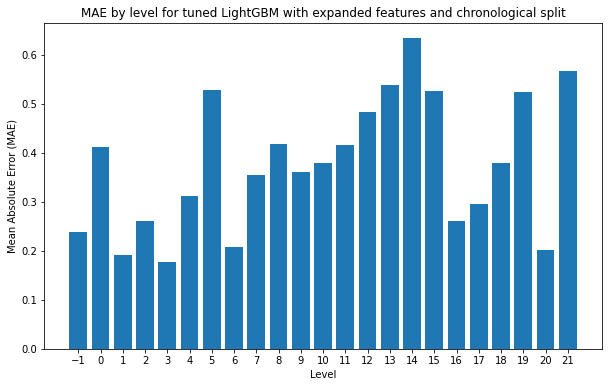

In [27]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with expanded features and chronological split",
)

In [28]:
predict = lgb_tuned.predict(X_test)
check_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.47

Round type: 0.5
RMSE: 0.49

Round type: 0.33
RMSE: 0.53

Round type: 0.45
RMSE: 0.49



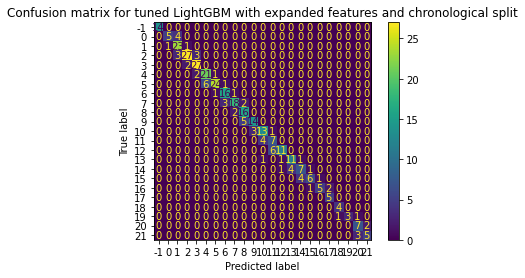

In [29]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with expanded features and chronological split",
)

## Random split

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 13
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 0.267273	valid_0's l2: 0.148111


In [31]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.38
MAE: 0.27


In [33]:
results.loc[2] = ["random", "default", "expanded", rmse, mae]

###### MAE by level

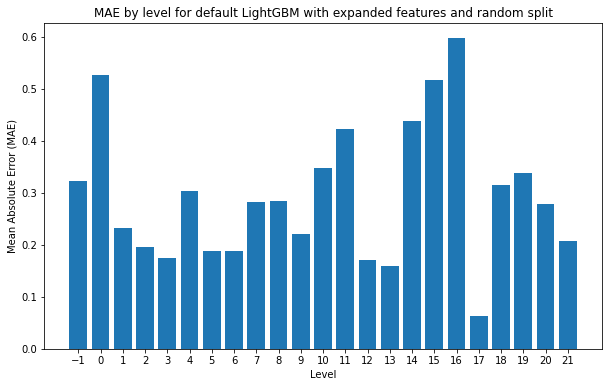

In [34]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with expanded features and random split",
)

In [35]:
check_round_predictions([0.5, 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
RMSE: 0.38

Round type: 0.5
RMSE: 0.39

Round type: 0.33
RMSE: 0.45

Round type: 0.45
RMSE: 0.41



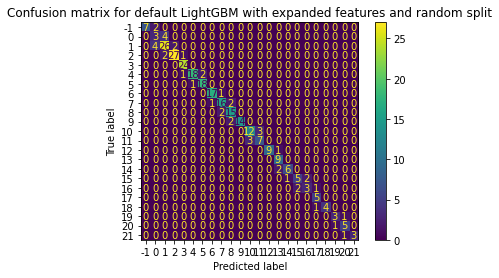

In [36]:
plot_confusion_matrix(
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with expanded features and random split",
)

### Tuning

In [37]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 14:01:37,220] A new study created in memory with name: no-name-34bdb72b-454f-408f-b9ed-e34da7951b6e
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.194725 + 0.0453077
[200]	cv_agg's l2: 0.191853 + 0.0434107
[300]	cv_agg's l2: 0.192368 + 0.0428342


feature_fraction, val_score: 0.191608:  14%|######4                                      | 1/7 [00:04<00:27,  4.65s/it]

Early stopping, best iteration is:
[216]	cv_agg's l2: 0.191608 + 0.0436806
[100]	cv_agg's l2: 0.170722 + 0.025656


feature_fraction, val_score: 0.169905:  29%|############8                                | 2/7 [00:07<00:18,  3.66s/it]

[200]	cv_agg's l2: 0.171152 + 0.0217836
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058
[100]	cv_agg's l2: 0.176461 + 0.0449111


feature_fraction, val_score: 0.169905:  43%|###################2                         | 3/7 [00:10<00:13,  3.28s/it]

[200]	cv_agg's l2: 0.175083 + 0.0403922
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058
[100]	cv_agg's l2: 0.183796 + 0.0504299


feature_fraction, val_score: 0.169905:  57%|#########################7                   | 4/7 [00:13<00:09,  3.15s/it]

[200]	cv_agg's l2: 0.183343 + 0.0475492
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058
[100]	cv_agg's l2: 0.173766 + 0.0471292


feature_fraction, val_score: 0.169905:  71%|################################1            | 5/7 [00:16<00:06,  3.05s/it]

[200]	cv_agg's l2: 0.17381 + 0.0430843
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058
[100]	cv_agg's l2: 0.184173 + 0.0408721


feature_fraction, val_score: 0.169905:  86%|######################################5      | 6/7 [00:19<00:03,  3.01s/it]

[200]	cv_agg's l2: 0.183542 + 0.0375784
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058
[100]	cv_agg's l2: 0.178512 + 0.0508529


feature_fraction, val_score: 0.169905:  86%|######################################5      | 6/7 [00:22<00:03,  3.01s/it]

[200]	cv_agg's l2: 0.1773 + 0.0472699
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058


num_leaves, val_score: 0.169905:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.170722 + 0.025656


num_leaves, val_score: 0.169905:   5%|##5                                               | 1/20 [00:03<00:57,  3.02s/it]

[200]	cv_agg's l2: 0.171152 + 0.0217836
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058
[100]	cv_agg's l2: 0.170722 + 0.025656


num_leaves, val_score: 0.169905:  10%|#####                                             | 2/20 [00:06<00:57,  3.19s/it]

[200]	cv_agg's l2: 0.171152 + 0.0217836
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058
[100]	cv_agg's l2: 0.170722 + 0.025656


num_leaves, val_score: 0.169905:  15%|#######5                                          | 3/20 [00:09<00:52,  3.07s/it]

[200]	cv_agg's l2: 0.171152 + 0.0217836
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058
[100]	cv_agg's l2: 0.170722 + 0.025656


num_leaves, val_score: 0.169905:  15%|#######5                                          | 3/20 [00:13<00:52,  3.07s/it]

[200]	cv_agg's l2: 0.171152 + 0.0217836
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058


num_leaves, val_score: 0.169905:  20%|##########                                        | 4/20 [00:13<00:54,  3.44s/it]

[100]	cv_agg's l2: 0.170722 + 0.025656


num_leaves, val_score: 0.169905:  25%|############5                                     | 5/20 [00:17<00:55,  3.70s/it]

[200]	cv_agg's l2: 0.171152 + 0.0217836
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058
[100]	cv_agg's l2: 0.170722 + 0.025656
[200]	cv_agg's l2: 0.171152 + 0.0217836


num_leaves, val_score: 0.169905:  30%|###############                                   | 6/20 [00:20<00:48,  3.50s/it]

Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058
[100]	cv_agg's l2: 0.170722 + 0.025656


num_leaves, val_score: 0.169905:  35%|#################5                                | 7/20 [00:23<00:43,  3.32s/it]

[200]	cv_agg's l2: 0.171152 + 0.0217836
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058
[100]	cv_agg's l2: 0.170722 + 0.025656


num_leaves, val_score: 0.169905:  40%|####################                              | 8/20 [00:27<00:41,  3.48s/it]

[200]	cv_agg's l2: 0.171152 + 0.0217836
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058
[100]	cv_agg's l2: 0.170722 + 0.025656


num_leaves, val_score: 0.169905:  45%|######################5                           | 9/20 [00:29<00:35,  3.22s/it]

[200]	cv_agg's l2: 0.171152 + 0.0217836
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058
[100]	cv_agg's l2: 0.170722 + 0.025656


num_leaves, val_score: 0.169905:  50%|########################5                        | 10/20 [00:32<00:31,  3.14s/it]

[200]	cv_agg's l2: 0.171152 + 0.0217836
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058
[100]	cv_agg's l2: 0.182879 + 0.0288457


num_leaves, val_score: 0.169905:  55%|##########################9                      | 11/20 [00:33<00:22,  2.46s/it]

[200]	cv_agg's l2: 0.175293 + 0.022155
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058
[100]	cv_agg's l2: 0.170722 + 0.025656


num_leaves, val_score: 0.169905:  60%|#############################4                   | 12/20 [00:36<00:20,  2.56s/it]

[200]	cv_agg's l2: 0.171152 + 0.0217836
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058
[100]	cv_agg's l2: 0.170722 + 0.025656


num_leaves, val_score: 0.169905:  65%|###############################8                 | 13/20 [00:39<00:18,  2.58s/it]

[200]	cv_agg's l2: 0.171152 + 0.0217836
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058
[100]	cv_agg's l2: 0.170722 + 0.025656


num_leaves, val_score: 0.169905:  65%|###############################8                 | 13/20 [00:41<00:18,  2.58s/it]

[200]	cv_agg's l2: 0.171152 + 0.0217836
Early stopping, best iteration is:
[111]	cv_agg's l2: 0.169905 + 0.0238058


num_leaves, val_score: 0.169905:  70%|##################################3              | 14/20 [00:41<00:15,  2.62s/it]

[100]	cv_agg's l2: 0.170342 + 0.0254767
[200]	cv_agg's l2: 0.168558 + 0.0211551


num_leaves, val_score: 0.168222:  75%|####################################7            | 15/20 [00:45<00:14,  2.81s/it]

Early stopping, best iteration is:
[184]	cv_agg's l2: 0.168222 + 0.0214685
[100]	cv_agg's l2: 0.170722 + 0.025656
[200]	cv_agg's l2: 0.171152 + 0.0217836


num_leaves, val_score: 0.168222:  80%|#######################################2         | 16/20 [00:48<00:12,  3.04s/it]

Early stopping, best iteration is:
[184]	cv_agg's l2: 0.168222 + 0.0214685
[100]	cv_agg's l2: 0.170722 + 0.025656
[200]	cv_agg's l2: 0.171152 + 0.0217836


num_leaves, val_score: 0.168222:  85%|#########################################6       | 17/20 [00:52<00:09,  3.21s/it]

Early stopping, best iteration is:
[184]	cv_agg's l2: 0.168222 + 0.0214685
[100]	cv_agg's l2: 0.170722 + 0.025656
[200]	cv_agg's l2: 0.171152 + 0.0217836


num_leaves, val_score: 0.168222:  90%|############################################1    | 18/20 [00:56<00:06,  3.46s/it]

Early stopping, best iteration is:
[184]	cv_agg's l2: 0.168222 + 0.0214685
[100]	cv_agg's l2: 0.341139 + 0.0598865


num_leaves, val_score: 0.168222:  95%|##############################################5  | 19/20 [00:57<00:02,  2.60s/it]

[200]	cv_agg's l2: 0.296509 + 0.045691
Early stopping, best iteration is:
[184]	cv_agg's l2: 0.168222 + 0.0214685
[100]	cv_agg's l2: 0.170722 + 0.025656
[200]	cv_agg's l2: 0.171152 + 0.0217836


num_leaves, val_score: 0.168222: 100%|#################################################| 20/20 [01:00<00:00,  3.03s/it]


Early stopping, best iteration is:
[184]	cv_agg's l2: 0.168222 + 0.0214685


bagging, val_score: 0.168222:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.183076 + 0.0350511
[200]	cv_agg's l2: 0.176708 + 0.0290916


bagging, val_score: 0.168222:  10%|#####3                                               | 1/10 [00:02<00:24,  2.75s/it]

Early stopping, best iteration is:
[184]	cv_agg's l2: 0.168222 + 0.0214685
[100]	cv_agg's l2: 0.165984 + 0.0202487
[200]	cv_agg's l2: 0.165033 + 0.0153393


bagging, val_score: 0.164718:  20%|##########6                                          | 2/10 [00:06<00:27,  3.46s/it]

[300]	cv_agg's l2: 0.165171 + 0.0148224
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898
[100]	cv_agg's l2: 0.167829 + 0.0239327
[200]	cv_agg's l2: 0.167068 + 0.0212724


bagging, val_score: 0.164718:  30%|###############9                                     | 3/10 [00:10<00:25,  3.65s/it]

[300]	cv_agg's l2: 0.168118 + 0.0213308
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898
[100]	cv_agg's l2: 0.173578 + 0.0253661
[200]	cv_agg's l2: 0.173545 + 0.0204588


bagging, val_score: 0.164718:  40%|#####################2                               | 4/10 [00:14<00:21,  3.57s/it]

[300]	cv_agg's l2: 0.174421 + 0.0208737
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898
[100]	cv_agg's l2: 0.170641 + 0.0254762
[200]	cv_agg's l2: 0.170061 + 0.0210132


bagging, val_score: 0.164718:  50%|##########################5                          | 5/10 [00:17<00:18,  3.65s/it]

[300]	cv_agg's l2: 0.170877 + 0.01951
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898
[100]	cv_agg's l2: 0.166914 + 0.0250172
[200]	cv_agg's l2: 0.165863 + 0.021681


bagging, val_score: 0.164718:  60%|###############################8                     | 6/10 [00:20<00:13,  3.43s/it]

[300]	cv_agg's l2: 0.166178 + 0.0211148
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898
[100]	cv_agg's l2: 0.170989 + 0.0282186
[200]	cv_agg's l2: 0.169216 + 0.0246182


bagging, val_score: 0.164718:  70%|#####################################                | 7/10 [00:23<00:09,  3.12s/it]

[300]	cv_agg's l2: 0.169932 + 0.0239549
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898
[100]	cv_agg's l2: 0.169375 + 0.0218711
[200]	cv_agg's l2: 0.167988 + 0.0186432


bagging, val_score: 0.164718:  80%|##########################################4          | 8/10 [00:25<00:05,  2.86s/it]

[300]	cv_agg's l2: 0.167964 + 0.0181991
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898
[100]	cv_agg's l2: 0.175527 + 0.02368
[200]	cv_agg's l2: 0.173959 + 0.0181218


bagging, val_score: 0.164718:  90%|###############################################7     | 9/10 [00:27<00:02,  2.68s/it]

[300]	cv_agg's l2: 0.174189 + 0.018992
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898
[100]	cv_agg's l2: 0.170367 + 0.0230202
[200]	cv_agg's l2: 0.168599 + 0.0175231


bagging, val_score: 0.164718: 100%|####################################################| 10/10 [00:30<00:00,  3.05s/it]


[300]	cv_agg's l2: 0.170481 + 0.0167836
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898


feature_fraction_stage2, val_score: 0.164718:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.165984 + 0.0202487
[200]	cv_agg's l2: 0.165033 + 0.0153393


feature_fraction_stage2, val_score: 0.164718:  33%|############6                         | 1/3 [00:03<00:06,  3.36s/it]

[300]	cv_agg's l2: 0.165171 + 0.0148224
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898
[100]	cv_agg's l2: 0.173889 + 0.0412572
[200]	cv_agg's l2: 0.174389 + 0.0389761


feature_fraction_stage2, val_score: 0.164718:  67%|#########################3            | 2/3 [00:05<00:02,  2.91s/it]

[300]	cv_agg's l2: 0.176172 + 0.0386821
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898
[100]	cv_agg's l2: 0.173889 + 0.0412572
[200]	cv_agg's l2: 0.174389 + 0.0389761


feature_fraction_stage2, val_score: 0.164718: 100%|######################################| 3/3 [00:08<00:00,  2.96s/it]


[300]	cv_agg's l2: 0.176172 + 0.0386821
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898


regularization_factors, val_score: 0.164718:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.16688 + 0.0239411
[200]	cv_agg's l2: 0.165962 + 0.0200114


regularization_factors, val_score: 0.164718:   5%|#9                                    | 1/20 [00:02<00:47,  2.51s/it]

[300]	cv_agg's l2: 0.166536 + 0.0186054
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898
[100]	cv_agg's l2: 0.169623 + 0.0253044
[200]	cv_agg's l2: 0.168702 + 0.0196862


regularization_factors, val_score: 0.164718:  10%|###8                                  | 2/20 [00:04<00:44,  2.47s/it]

[300]	cv_agg's l2: 0.169696 + 0.0188505
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898
[100]	cv_agg's l2: 0.226693 + 0.0545183
[200]	cv_agg's l2: 0.218311 + 0.0519813


regularization_factors, val_score: 0.164718:  15%|#####7                                | 3/20 [00:05<00:30,  1.78s/it]

[300]	cv_agg's l2: 0.215476 + 0.0512368
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898
[100]	cv_agg's l2: 0.185246 + 0.0317459
[200]	cv_agg's l2: 0.176238 + 0.025778


regularization_factors, val_score: 0.164718:  20%|#######6                              | 4/20 [00:08<00:36,  2.28s/it][I 2023-11-05 14:03:48,602] Trial 43 finished with value: 0.17647431140568054 and parameters: {'lambda_l1': 1.4581620383329756e-08, 'lambda_l2': 6.8247505359785965}. Best is trial 40 with value: 0.1659175035317467.


[300]	cv_agg's l2: 0.174089 + 0.0257213
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898


regularization_factors, val_score: 0.164718:  20%|#######6                              | 4/20 [00:08<00:36,  2.28s/it]

[100]	cv_agg's l2: 0.167786 + 0.0219369
[200]	cv_agg's l2: 0.16684 + 0.0168931


regularization_factors, val_score: 0.164718:  25%|#########5                            | 5/20 [00:11<00:37,  2.52s/it]

[300]	cv_agg's l2: 0.166519 + 0.017038
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898
[100]	cv_agg's l2: 0.167331 + 0.0222207
[200]	cv_agg's l2: 0.165972 + 0.0174738


regularization_factors, val_score: 0.164718:  30%|###########4                          | 6/20 [00:14<00:36,  2.58s/it]

[300]	cv_agg's l2: 0.167025 + 0.0164543
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.164718 + 0.0147898
[100]	cv_agg's l2: 0.166666 + 0.0209825
[200]	cv_agg's l2: 0.165253 + 0.0177658
[300]	cv_agg's l2: 0.164658 + 0.0160186


regularization_factors, val_score: 0.164583:  35%|#############3                        | 7/20 [00:18<00:38,  2.96s/it]

[400]	cv_agg's l2: 0.165865 + 0.015954
Early stopping, best iteration is:
[305]	cv_agg's l2: 0.164583 + 0.0160935
[100]	cv_agg's l2: 0.16414 + 0.0226703
[200]	cv_agg's l2: 0.162422 + 0.018532


regularization_factors, val_score: 0.161777:  40%|###############2                      | 8/20 [00:20<00:32,  2.73s/it]

Early stopping, best iteration is:
[162]	cv_agg's l2: 0.161777 + 0.0189921
[100]	cv_agg's l2: 0.170132 + 0.0268073
[200]	cv_agg's l2: 0.168213 + 0.0222518


regularization_factors, val_score: 0.161777:  45%|#################1                    | 9/20 [00:22<00:28,  2.57s/it]

Early stopping, best iteration is:
[162]	cv_agg's l2: 0.161777 + 0.0189921
[100]	cv_agg's l2: 0.167299 + 0.0243816
[200]	cv_agg's l2: 0.164385 + 0.0192551


regularization_factors, val_score: 0.161777:  50%|##################5                  | 10/20 [00:25<00:24,  2.48s/it]

Early stopping, best iteration is:
[162]	cv_agg's l2: 0.161777 + 0.0189921
[100]	cv_agg's l2: 0.16545 + 0.0203354
[200]	cv_agg's l2: 0.164756 + 0.0154609


regularization_factors, val_score: 0.161777:  55%|####################3                | 11/20 [00:27<00:22,  2.48s/it]

Early stopping, best iteration is:
[162]	cv_agg's l2: 0.161777 + 0.0189921
[100]	cv_agg's l2: 0.16545 + 0.0203354
[200]	cv_agg's l2: 0.164903 + 0.0153662


regularization_factors, val_score: 0.161777:  60%|######################2              | 12/20 [00:30<00:20,  2.58s/it]

Early stopping, best iteration is:
[162]	cv_agg's l2: 0.161777 + 0.0189921
[100]	cv_agg's l2: 0.165598 + 0.020282
[200]	cv_agg's l2: 0.165598 + 0.0152608


regularization_factors, val_score: 0.161777:  65%|########################             | 13/20 [00:33<00:18,  2.63s/it]

Early stopping, best iteration is:
[162]	cv_agg's l2: 0.161777 + 0.0189921
[100]	cv_agg's l2: 0.165321 + 0.0202712
[200]	cv_agg's l2: 0.164958 + 0.0153822


regularization_factors, val_score: 0.161777:  70%|#########################9           | 14/20 [00:35<00:16,  2.70s/it]

Early stopping, best iteration is:
[162]	cv_agg's l2: 0.161777 + 0.0189921
[100]	cv_agg's l2: 0.165079 + 0.0204816
[200]	cv_agg's l2: 0.164362 + 0.0157371


regularization_factors, val_score: 0.161777:  75%|###########################7         | 15/20 [00:38<00:13,  2.61s/it]

Early stopping, best iteration is:
[162]	cv_agg's l2: 0.161777 + 0.0189921
[100]	cv_agg's l2: 0.166204 + 0.0214109
[200]	cv_agg's l2: 0.166002 + 0.0159231


regularization_factors, val_score: 0.161777:  80%|#############################6       | 16/20 [00:41<00:10,  2.71s/it]

Early stopping, best iteration is:
[162]	cv_agg's l2: 0.161777 + 0.0189921
[100]	cv_agg's l2: 0.167044 + 0.0233304
[200]	cv_agg's l2: 0.166517 + 0.0204303


regularization_factors, val_score: 0.161777:  85%|###############################4     | 17/20 [00:44<00:08,  2.73s/it]

Early stopping, best iteration is:
[162]	cv_agg's l2: 0.161777 + 0.0189921
[100]	cv_agg's l2: 0.165732 + 0.0206262
[200]	cv_agg's l2: 0.164934 + 0.0164114


regularization_factors, val_score: 0.161777:  90%|#################################3   | 18/20 [00:47<00:05,  2.79s/it]

Early stopping, best iteration is:
[162]	cv_agg's l2: 0.161777 + 0.0189921
[100]	cv_agg's l2: 0.165766 + 0.0206214
[200]	cv_agg's l2: 0.164225 + 0.0160751


regularization_factors, val_score: 0.161777:  95%|###################################1 | 19/20 [00:49<00:02,  2.72s/it]

Early stopping, best iteration is:
[162]	cv_agg's l2: 0.161777 + 0.0189921
[100]	cv_agg's l2: 0.165732 + 0.0206263
[200]	cv_agg's l2: 0.165176 + 0.0162301


regularization_factors, val_score: 0.161777: 100%|#####################################| 20/20 [00:51<00:00,  2.60s/it]


Early stopping, best iteration is:
[162]	cv_agg's l2: 0.161777 + 0.0189921


min_data_in_leaf, val_score: 0.161777:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.715737 + 0.0870661


min_data_in_leaf, val_score: 0.161777:  20%|#########                                    | 1/5 [00:00<00:03,  1.33it/s]

[200]	cv_agg's l2: 0.675372 + 0.0807818
Early stopping, best iteration is:
[162]	cv_agg's l2: 0.161777 + 0.0189921
[100]	cv_agg's l2: 0.155774 + 0.0243936
[200]	cv_agg's l2: 0.1545 + 0.0215688


min_data_in_leaf, val_score: 0.153777:  40%|##################                           | 2/5 [00:03<00:05,  1.69s/it]

Early stopping, best iteration is:
[154]	cv_agg's l2: 0.153777 + 0.0221953
[100]	cv_agg's l2: 0.182551 + 0.0222966
[200]	cv_agg's l2: 0.179001 + 0.0178295


min_data_in_leaf, val_score: 0.153777:  60%|###########################                  | 3/5 [00:05<00:03,  1.89s/it]

Early stopping, best iteration is:
[154]	cv_agg's l2: 0.153777 + 0.0221953
[100]	cv_agg's l2: 0.243292 + 0.0348073
[200]	cv_agg's l2: 0.230799 + 0.0323304


min_data_in_leaf, val_score: 0.153777:  80%|####################################         | 4/5 [00:06<00:01,  1.60s/it]

Early stopping, best iteration is:
[154]	cv_agg's l2: 0.153777 + 0.0221953
[100]	cv_agg's l2: 0.152812 + 0.0251797
[200]	cv_agg's l2: 0.14971 + 0.0222588
[300]	cv_agg's l2: 0.148796 + 0.0211707


min_data_in_leaf, val_score: 0.148793: 100%|#############################################| 5/5 [00:09<00:00,  1.95s/it]

Early stopping, best iteration is:
[298]	cv_agg's l2: 0.148793 + 0.021121


In [38]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.14879257718344796
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.1268951391818605
    lambda_l2: 0.03729550505892705
    num_leaves: 23
    feature_fraction: 0.4
    bagging_fraction: 0.9483214622091305
    bagging_freq: 1
    min_child_samples: 10


In [39]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [40]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.02
RMSE test: 0.35
MAE test: 0.24



In [41]:
results.loc[3] = ["random", "Optuna", "expanded", rmse, mae]

###### MAE by level

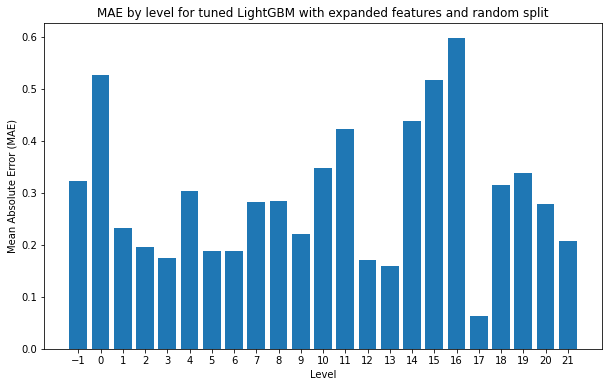

In [42]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with expanded features and random split",
)

In [43]:
predict = lgb_tuned.predict(X_test)
check_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.21

Round type: 0.5
RMSE: 0.24

Round type: 0.33
RMSE: 0.23

Round type: 0.45
RMSE: 0.23



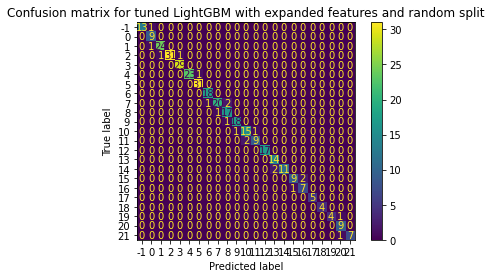

In [44]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with expanded features and random split",
)

## Summary

In [45]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,expanded,0.510772,0.357206
1,chronological,Optuna,expanded,0.470867,0.335287
2,random,default,expanded,0.384853,0.267273
3,random,Optuna,expanded,0.349687,0.243844


In [46]:
from training.results import plot_summary

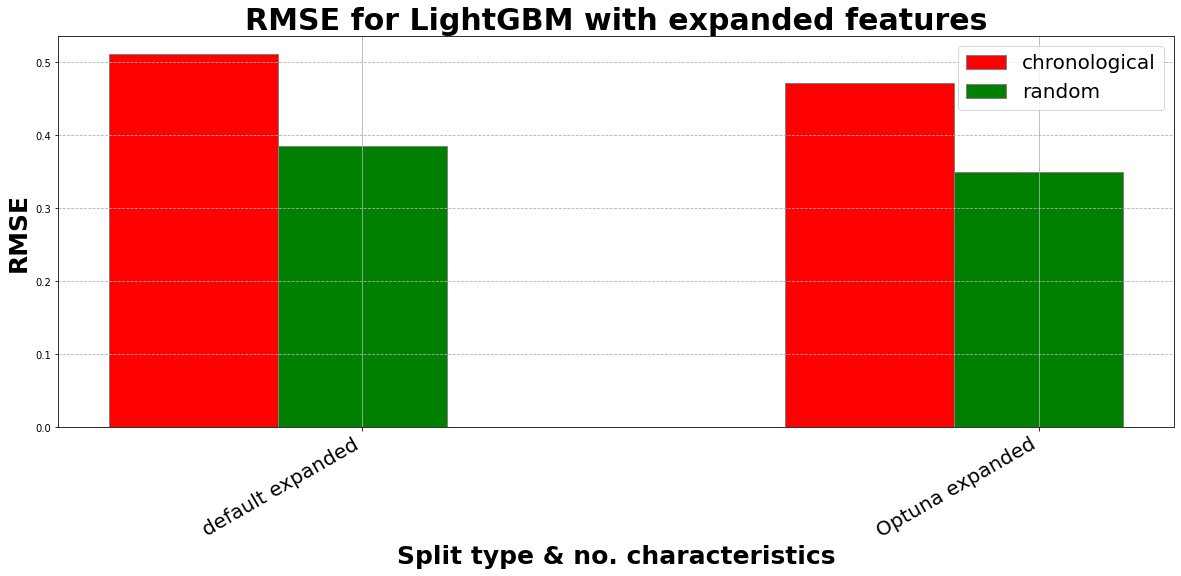

In [47]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with expanded features")

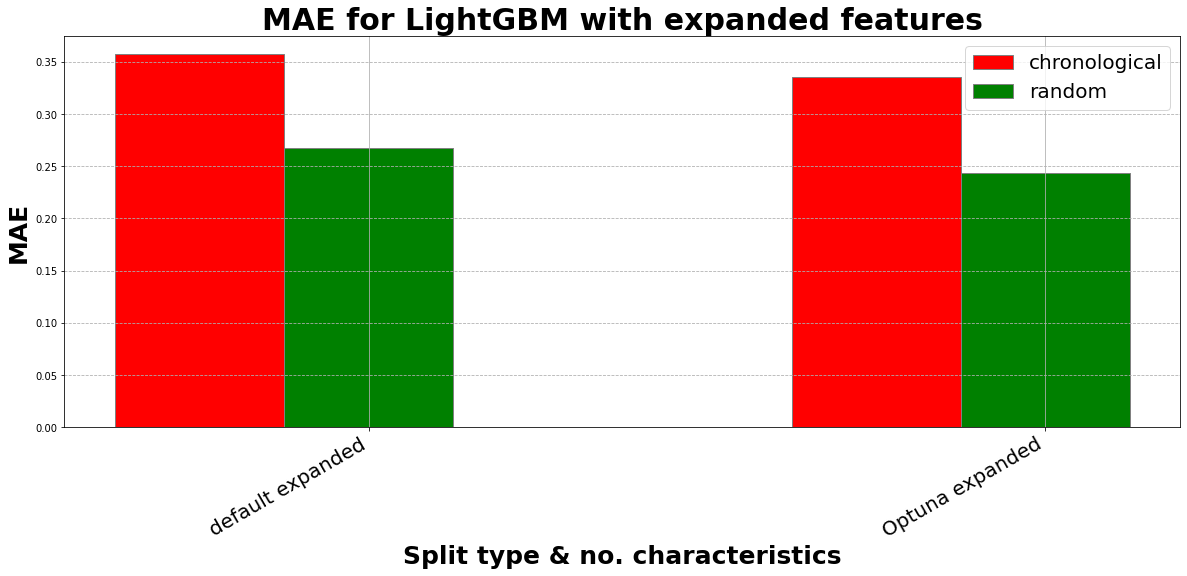

In [48]:
plot_summary(results, "MAE", title="MAE for LightGBM with expanded features")

In [49]:
results.to_json("./lightgbm_expanded_results.json", indent=2)